# 0. Read, Inspect, Preprocess and Split Data

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.4/352.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 44.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 12.0 MB/s e

Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
from torch import nn
import torch

In [ ]:
basePath = "/content/gdrive/My Drive/S2S/new-test/"

In [ ]:
stationPath = f"{basePath}station.csv"

In [ ]:
pathY = f"{basePath}y.80-19.tsv"

In [ ]:
pathYTest = f"{basePath}R2023.csv"

In [ ]:
station = pd.read_csv(stationPath)

In [ ]:
def isExtreme(value):
    if value >= 50:
        return 1
    else:
        return 0

In [ ]:
def classify(p, epsilon=0.5):
    score = 1 / (1 + np.exp(-p))
    if score >= epsilon:
        return 1.0
    else:
        return 0.0

In [ ]:
def preprocessingDfY(dfY, sit_name, situation):
  # dfY.loc[dfY[3] == '-'] # search for an anomaly line
  dfY = dfY.replace(["      "], [0])
  dfY = dfY.replace(["."], [0])
  # dfY.loc[dfY[22] == '      ']
  dfY = dfY.replace(["3.9*"], [3.9])
  dfY = dfY.replace(["####"], [0])
  dfY = dfY.replace(["6.1."], [6.1])
  dfY = dfY.replace(["42.1."], [42.1])
  dfY = dfY.replace(["-"], [0])
  dfY = dfY.replace(["--"], [0])
  dfY = dfY.replace(["---"], [0])
  dfY = dfY.replace(["x"], [0])
  dfY[sit_name] = pd.to_numeric(dfY.loc[:,situation+3])
  dfY['Date'] = dfY.loc[:, 0:2].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
  dfY['Date'] = pd.to_datetime(dfY['Date'])
  return dfY

In [ ]:
def predfYTest(dfYTest, sit_name, situation):
  dfYTest = dfYTest.replace(["-"], [0])
  dfYTest = dfYTest.replace(["."], [0])
  dfYTest[sit_name] = pd.to_numeric(dfYTest.loc[:, situation + 3])
  dfYTest['Date'] = dfYTest.loc[:, 0:2].astype(int).apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
  dfYTest['Date'] = pd.to_datetime(dfYTest['Date'])
  return dfYTest

In [ ]:
def preprocessing(situation):
  dfY = pd.read_csv(pathY, delimiter="\t", header=None)
  dfYTest = pd.read_csv(pathYTest, delimiter=";", header=None)
  dfYTest = dfYTest.T
  sit_name = (station.loc[:, 'name'])[situation]
  dfY = preprocessingDfY(dfY, sit_name, situation)
  dfYTest = predfYTest(dfYTest, sit_name, situation)
  dfY = pd.concat([dfY, dfYTest], axis=0)
  y = dfY[sit_name].apply(lambda v: isExtreme(v))
  dfY['y'] = y
  df = pd.DataFrame()
  df[sit_name] = dfY[sit_name]
  df['Date'] = dfY['Date']
  df['y'] = dfY['y']
  features = list(df.columns.values)[0:-2]
  train_df = df[:15347]
  test_df = df[15347:]
  train, valid, test = TSDataset.from_pandas(train_df, dt_col='Date', target_col='y', extra_feature_col=features, with_split=True, val_ratio=0.01, test_ratio=0.01, repair=True)
  outside_test = TSDataset.from_pandas(test_df, dt_col='Date', target_col='y',extra_feature_col=features, with_split=False)
  return train, valid, test, outside_test

In [ ]:
def trainTest(train, valid, test, outside_test):
  scaler = StandardScaler()
  for data in [train, valid, test]:
      data.deduplicate() \
          .impute() \
          .gen_dt_feature() \
          .scale(scaler, fit=(data is train)) \
          .roll(lookback=lookback, horizon=horizon)
  print(train.to_numpy()[1][1].shape)
  X, y = train.to_numpy()
  print(X.shape, y.shape)
  print(X.shape[-1])
  outside_test.deduplicate() \
        .impute() \
        .gen_dt_feature() \
        .scale(scaler, fit=False) \
        .roll(lookback=lookback, horizon=horizon)
  X_ot, y_ot = outside_test.to_numpy()
  print(X_ot.shape, y_ot.shape)
  print(y_ot[:,:,0][:,-1][:10])
  return X, y, outside_test, X_ot, y_ot

In [ ]:
def training(X, y):
  extreme_weight = torch.full([1], 9.0) # make the extreme sample a large weight
  loss = nn.BCEWithLogitsLoss(pos_weight=extreme_weight)
  model = TCNForecaster(past_seq_len=lookback, future_seq_len=horizon, input_feature_num=X.shape[-1], output_feature_num=y.shape[-1], optimizer='Adam', loss=loss, lr=1e-5)
  model.fit((X, y), batch_size=32, epochs=10)
  return model

In [ ]:
lookback, horizon = 7, 7

In [ ]:
def result(fig_name):
  plt.figure(figsize=(24,6))
  plt.plot(ot_predict[:,:,0][:,-1][horizon:horizon+366]) # shift horizon time steps
  plt.plot(y_ot[:,:,0][:,-1][0:365])
  plt.legend(["prediction (TCN)", "ground truth"])
  plt.title(f'Extreme Precipitation on the {fig_name}')
  plt.xlabel('Day')
  plt.ylabel('Extreme')
  plt.savefig(f"{basePath}/image/{fig_name}.png")
  y_ot_predict = [classify(p) for p in ot_predict[:,:,0][:,-1]][horizon:]
  print(sum(y_ot_predict))
  # y_ot_gold = yy_gold.to_numpy()[:-horizon]
  y_ot_gold = [classify(p) for p in y_ot[:,:,0][:,-1][:-horizon]]
  print((y_ot_gold))
  # y_test_gold = test.unscale_numpy(y_test)[:,:,0][:,-1][:-horizon]
  print(len(y_ot_predict), len(y_ot_gold))
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_ot_gold, y_ot_predict)
  auc = (sklearn.metrics.auc(fpr, tpr))
  classification_report = sklearn.metrics.classification_report(y_ot_gold, y_ot_predict)
  with open(f'/content/gdrive/My Drive/S2S/new-test/res/{fig_name}.txt', 'w') as file:
    file.write(str(fig_name))
    file.write('\n')
    file.write(str(auc))
    file.write('\n')
    file.write(classification_report)

In [ ]:
(station.loc[:, 'name'])[2]

'Tam Duong'

split


<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.11956719 -0.11956719 -0.11956719 -0.11956719 -0.11956719 -0.11956719
 -0.11956719 -0.11956719 -0.11956719 -0.11956719]
training


Training: 0it [00:00, ?it/s]

predict
result
6.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.1251645 -0.1251645 -0.1251645 -0.1251645 -0.1251645 -0.1251645
 -0.1251645 -0.1251645 -0.1251645 -0.1251645]
training


Training: 0it [00:00, ?it/s]

predict
result
2.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.13288717 -0.13288717 -0.13288717 -0.13288717 -0.13288717 -0.13288717
 -0.13288717 -0.13288717 -0.13288717 -0.13288717]
training


Training: 0it [00:00, ?it/s]

predict
result
8.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.10974579 -0.10974579 -0.10974579 -0.10974579 -0.10974579 -0.10974579
 -0.10974579 -0.10974579 -0.10974579 -0.10974579]
training


Training: 0it [00:00, ?it/s]

predict
result
3.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.08504295 -0.08504295 -0.08504295 -0.08504295 -0.08504295 -0.08504295
 -0.08504295 -0.08504295 -0.08504295 -0.08504295]
training


Training: 0it [00:00, ?it/s]

predict
result
5.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.10036533 -0.10036533 -0.10036533 -0.10036533 -0.10036533 -0.10036533
 -0.10036533 -0.10036533 -0.10036533 -0.10036533]
training


Training: 0it [00:00, ?it/s]

predict
result
13.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.10170839 -0.10170839 -0.10170839 -0.10170839 -0.10170839 -0.10170839
 -0.10170839 -0.10170839 -0.10170839 -0.10170839]
training


Training: 0it [00:00, ?it/s]

predict
result
4.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.11956719 -0.11956719 -0.11956719 -0.11956719 -0.11956719 -0.11956719
 -0.11956719 -0.11956719 -0.11956719 -0.11956719]
training


Training: 0it [00:00, ?it/s]

predict
result
3.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-201-c27fd484163c>:3: DtypeWarning: Columns (5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,29,30,31,33,34,35,36,37,38,39,40,42,44,45,47,48,51,52,54,55,57,58,59,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,94,96,97,99,100,103,104,105,106,108,110,112,113,114,115,116,117,119,120,121,123,124,125,127,128,129,130,133,135,138,139,140,141,143,144,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  train, valid, test, outside_test = preprocessing(i)
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.seed:Global seed set to 1338802219
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 H

train test
(7, 1)
(15028, 7, 9) (15028, 7, 1)
9
(323, 7, 9) (323, 7, 1)
[-0.11985289 -0.11985289 -0.11985289 -0.11985289 -0.11985289 -0.11985289
 -0.11985289 -0.11985289 -0.11985289 -0.11985289]
training


Training: 0it [00:00, ?it/s]

predict
result
3.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

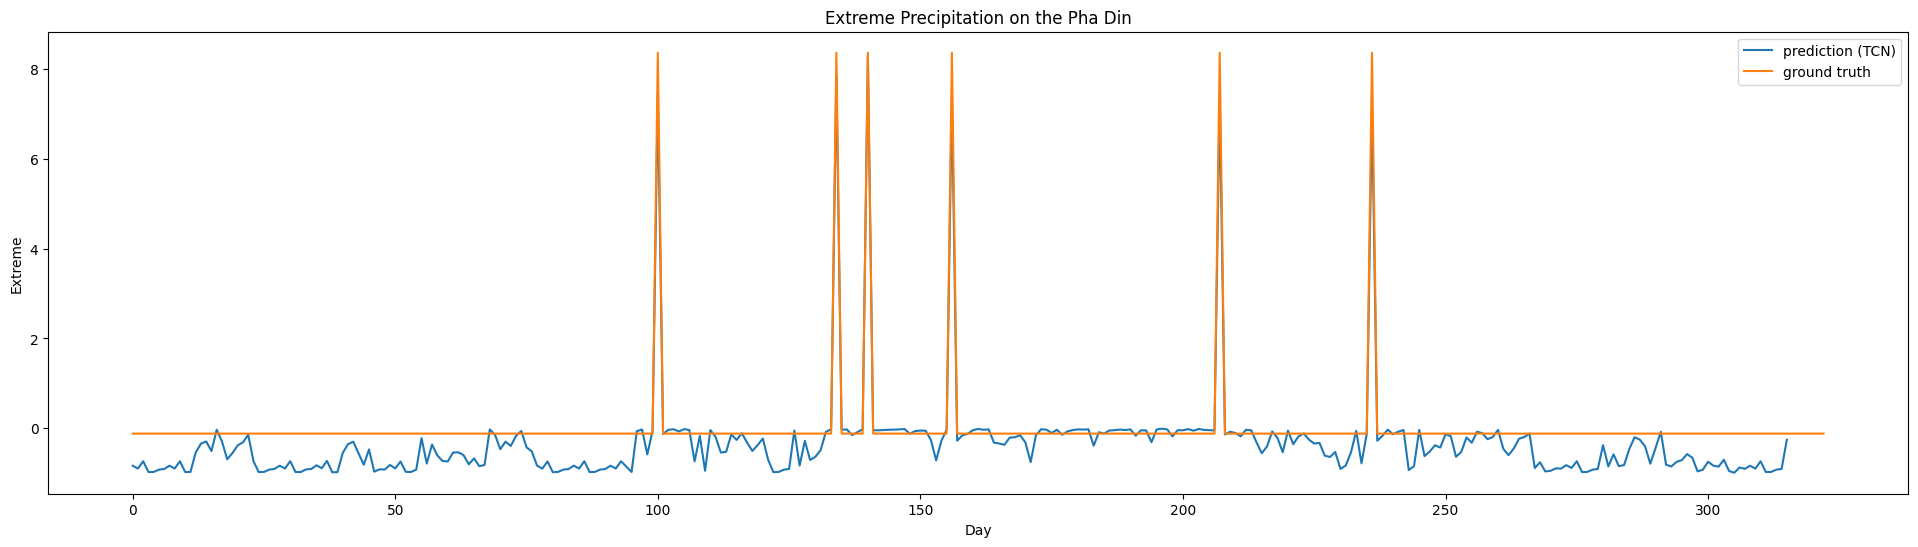

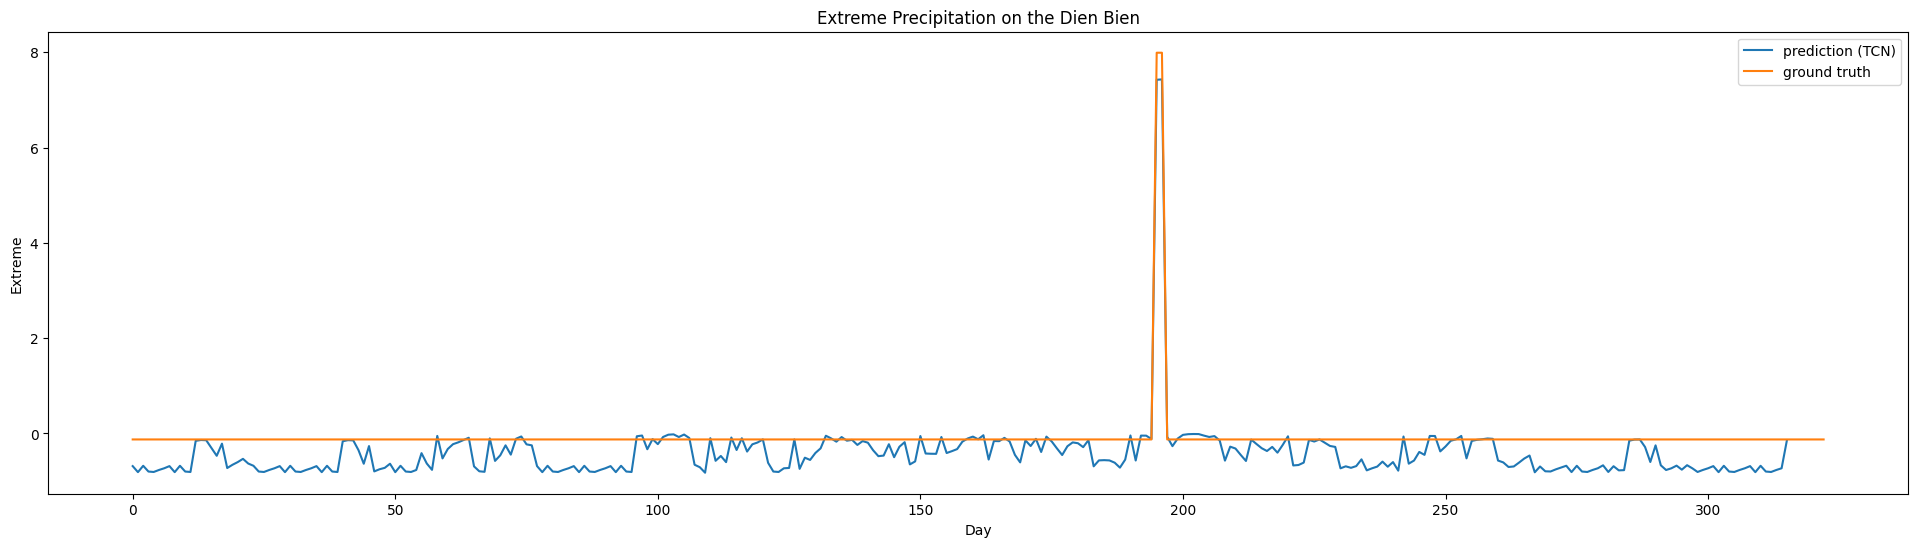

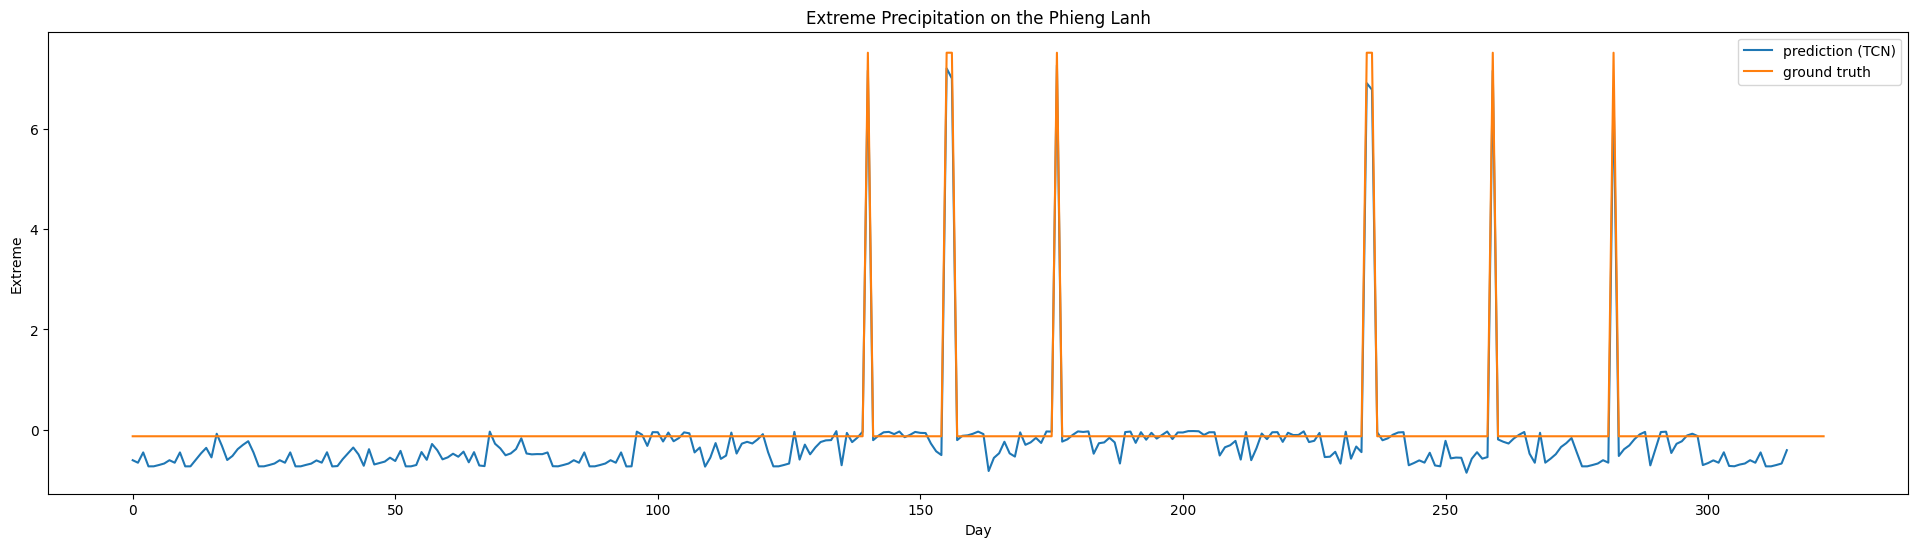

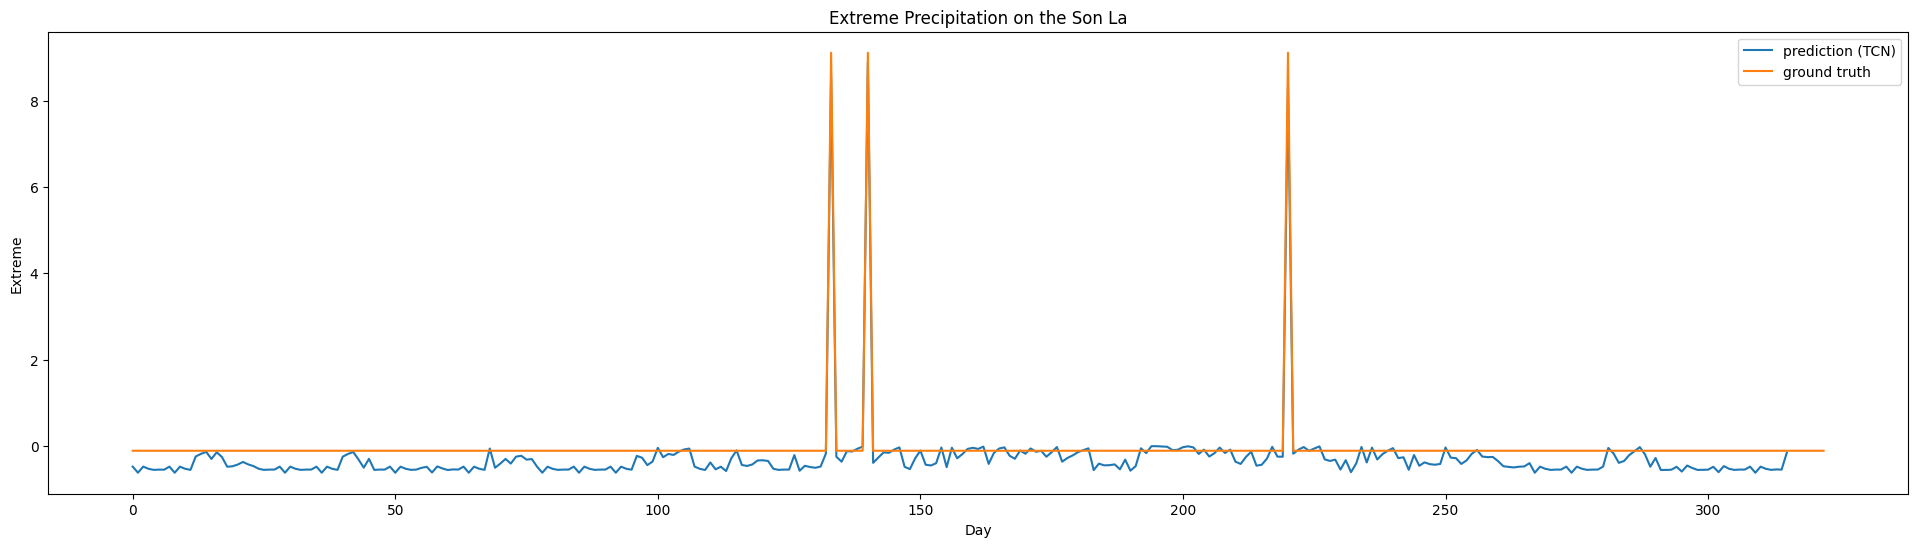

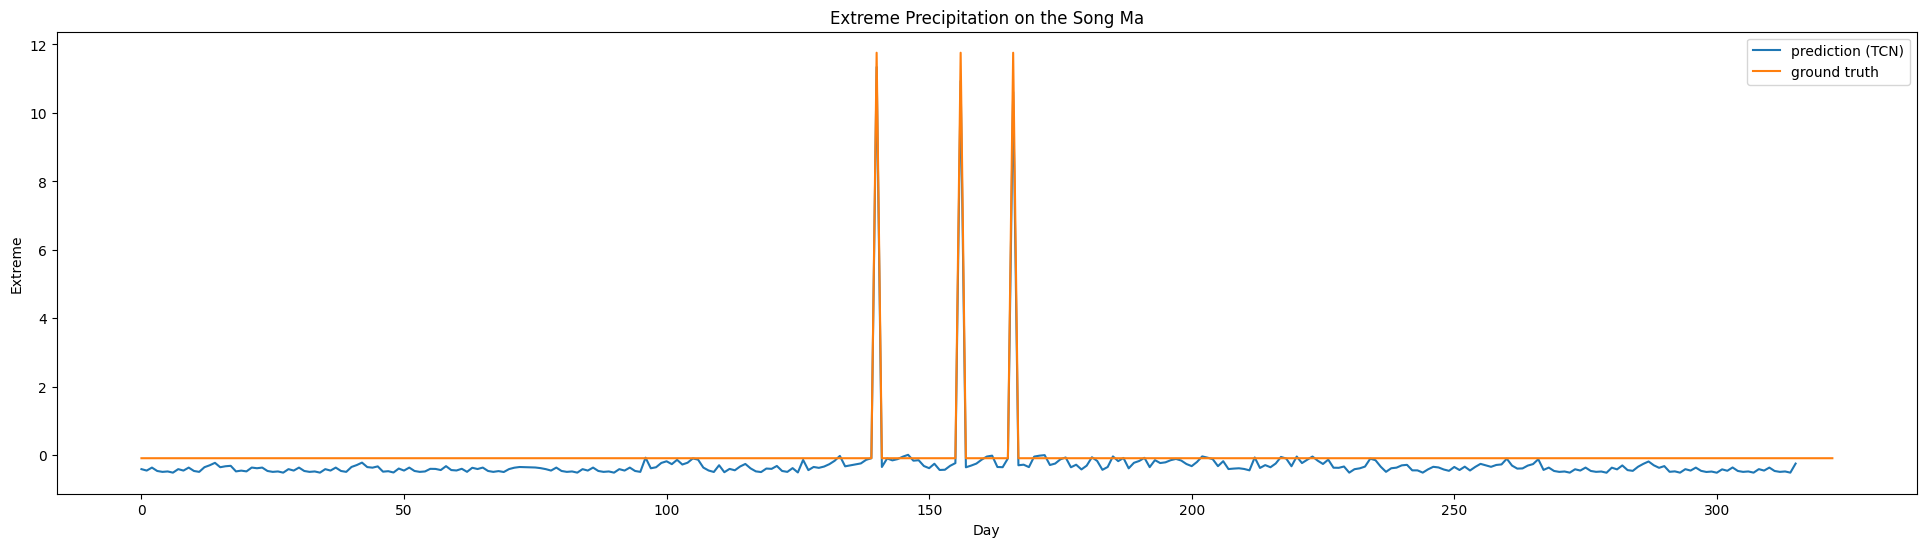

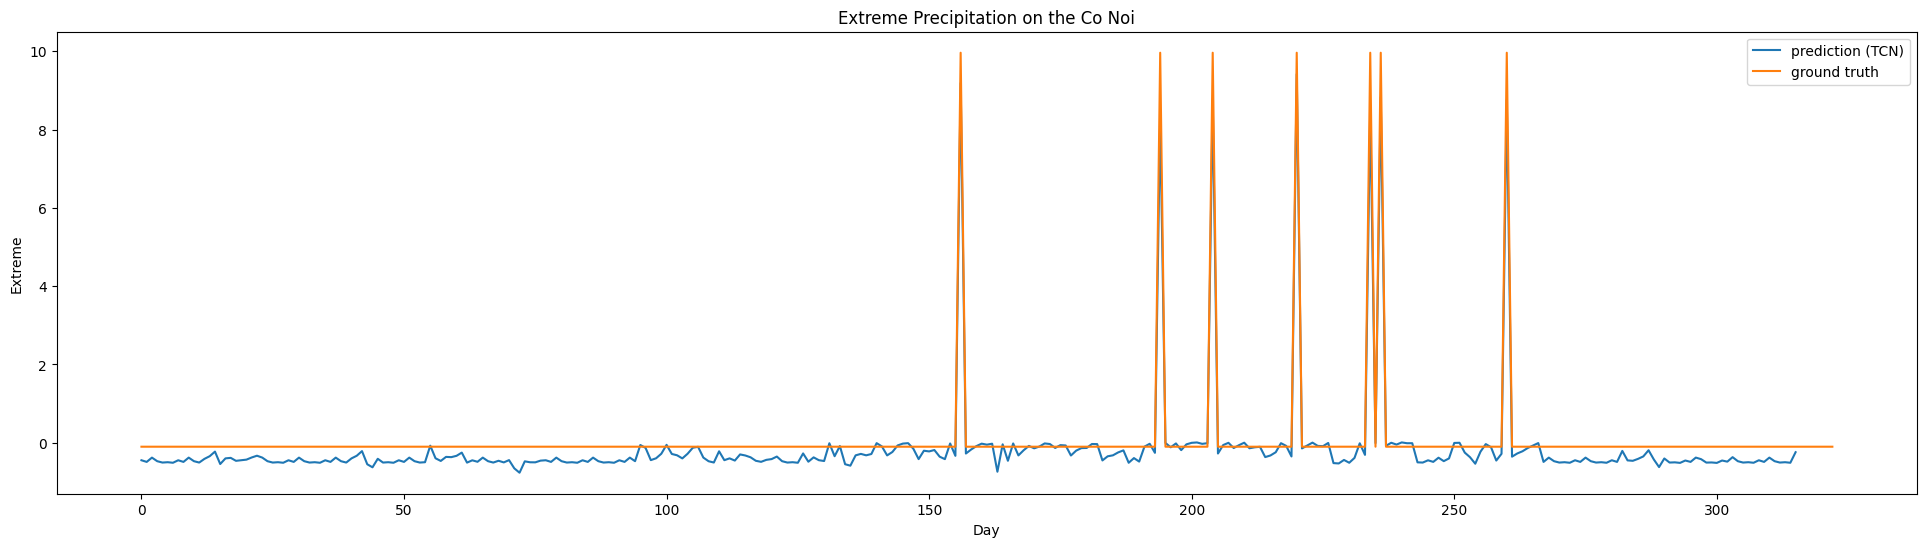

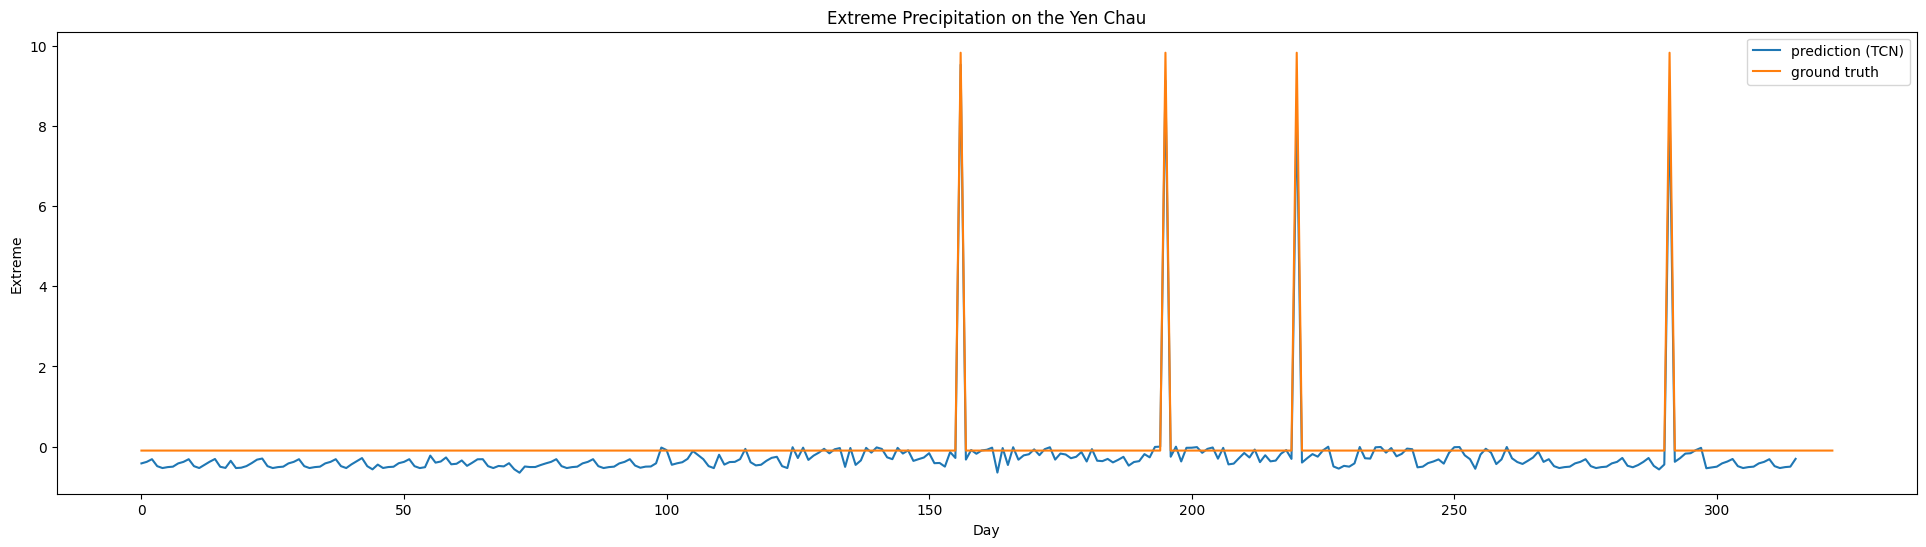

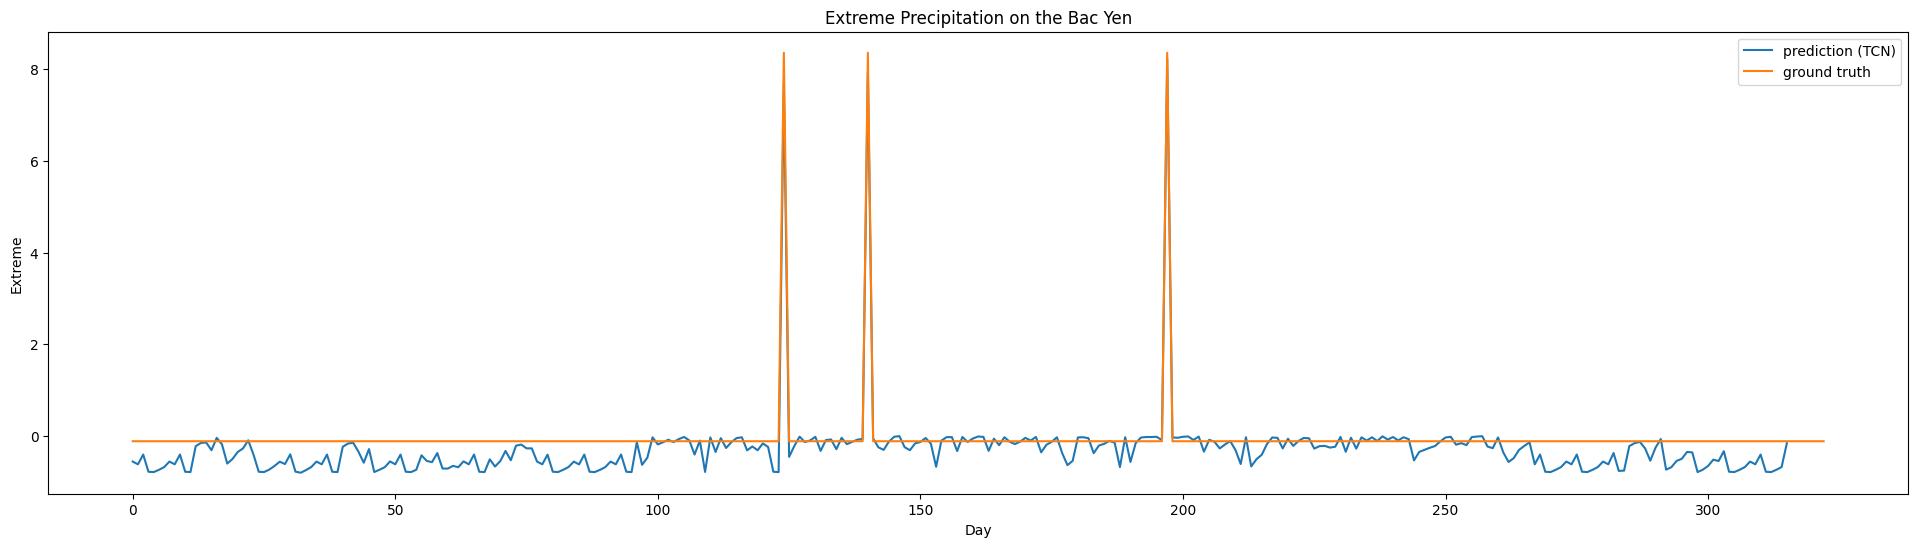

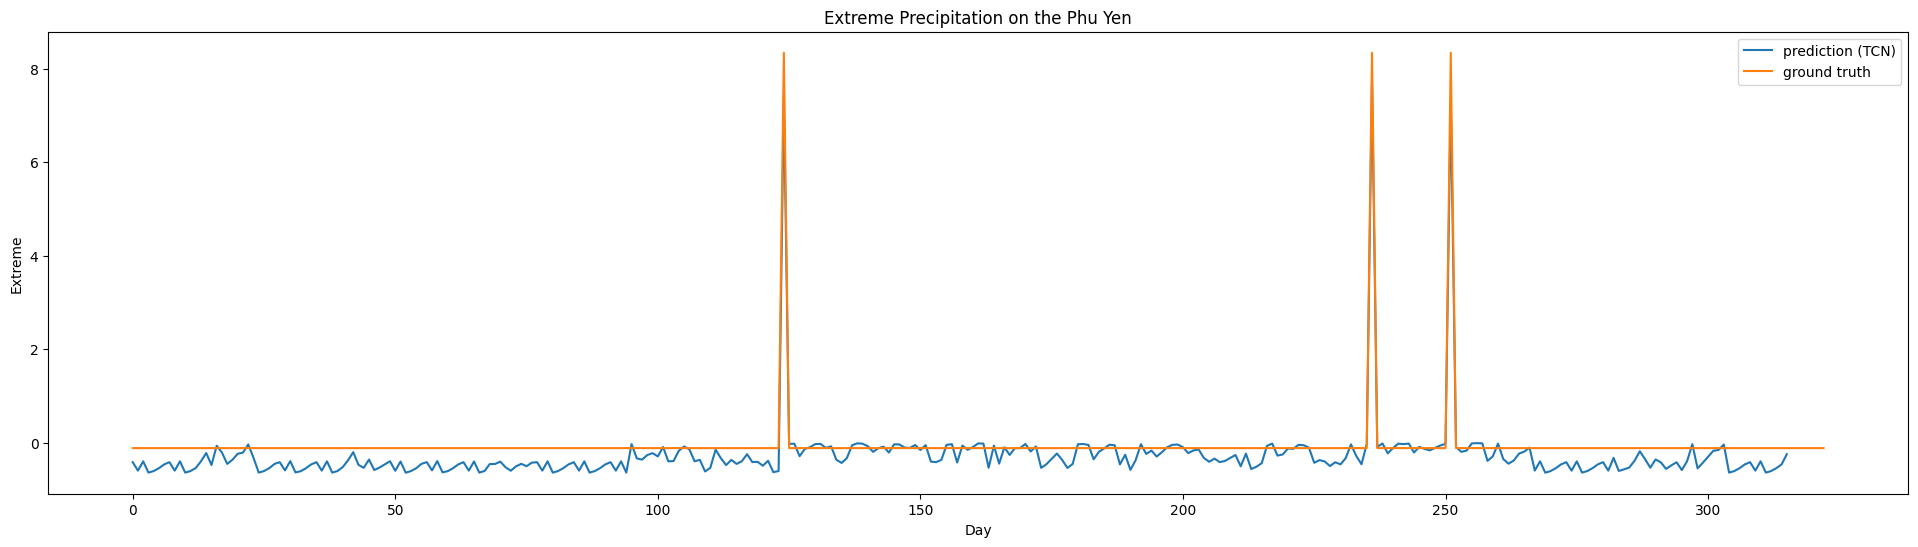

In [ ]:
for i in range(6, 15):
  print("split")
  train, valid, test, outside_test = preprocessing(i)
  print("train test")
  X, y, outside_test, X_ot, y_ot = trainTest(train, valid, test, outside_test)
  print("training")
  model = training(X, y)
  print("predict")
  ot_predict = model.predict(outside_test)
  print("result")
  result((station.loc[:, 'name'])[i])